In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from Resources.Model import Model_v25
from Resources.Game import *
from Resources.TS_ModelGuided_SensAnalysis import *

##### Setup Model

In [2]:
model = Model_v25()
model.eval()
model.load_state_dict(torch.load('../Train Value Function/Monte Carlo/Model Saves MC v25/model_2000_batches'))

<All keys matched successfully>

In [71]:
# # Tree Search guided by value function and sensitivity analysis of the value function

# # import time
# # import numpy as np
# # import random
# # import torch
# # import torch.autograd.functional as Func
# # import sys, os

# # project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
# # sys.path.append(project_root)

# # from Resources.Game import *
# # from Resources.RollingMedian import RollingMedian

# def sensitivity_extraction_1(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 1: 2-norm of gradient
#     '''
#     return torch.norm(grad, p=2).item()

# def sensitivity_extraction_2(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 2: unweighted sum of gradient
#     '''
#     return torch.sum(grad).item()

# def sensitivity_extraction_3(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 3: activation function -> sum of gradient
#     '''
#     return torch.sum(torch.tanh(grad)).item()

# def sensitivity_extraction_4(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 4: pooling over each piece type -> act. function -> then sum
#     '''
#     return torch.sum(torch.tanh(torch.sum(grad, dim=(1, 2)))).item()

# def sensitivity_extraction_5(grad):
#     '''
#     extract scalar value from model gradient.
#     R^(12*8*8) -> R
#     method 5: learned extraction function (e.g. NN)

#     possible future implementation
#     '''
#     return None

# def SensAnalysis_TS_prints(game, model, root=None, tmax=60, batches=10, prints=False, factors=None, factor_wins=1, 
#                    factor_mat=0, factor_value_sum=0.5, factor_value_indi=0.5, 
#                    factor_grad_sum=0.1, factor_grad_indi=0.1,
#                    factor_explore=1e-3,
#                    sensitivity_extraction = sensitivity_extraction_1, 
#                    use_gradients=True):
#     '''
#     Tree Search Guided by model and its sensitivity via model gradient
#     '''

#     # Create the root node if not passed
#     if root is None:
#         if factors is None:
#             root = SensAnalysis_Node(None, None, game, [factor_wins, factor_mat, 
#                                 factor_value_sum, factor_value_indi, 
#                                 factor_grad_sum, factor_grad_indi,
#                                 factor_explore]) 
#         if factors is not None:
#             root = SensAnalysis_Node(None, None, game, factors) 

#     root.game.FlipBoard()
#     board_batch = [board_to_tensor(root.game.pieces)]
#     nodes = [root]
#     root.game.FlipBoard()

#     for _ in range(batches):

#         t0 = time.time()
#         while time.time() - t0 < float(tmax) / float(batches):

#             node = root

#             # Selection
#             while not node.is_leaf() and node.is_fully_expanded():
#                 node = node.select_child()
#                 # print('select: ', node.move)

#             # Expansion
#             if not node.is_fully_expanded():
#                 node, board_batch = node.expand(board_batch)
#                 # print('exp: ', node.move)

#             if node.game.is_over():
#                 winner = node.game.get_winner()
#             else:
#                 winner = None

#             # backpropagation of winner, matdiff
#             for_side = node.player

#             node.backpropagate(winner, node.matdiff, for_side, prints)
            
#             nodes.append(node)
#             # board_batch.append(board_to_tensor(node.game.pieces))

#         batch_size = len(board_batch)

#         if batch_size == 0:
#             continue

#         # get model values
#         tens_board_batch = torch.stack(board_batch)
#         tens_board_batch.requires_grad = True
#         values = model(tens_board_batch).detach().numpy().flatten()

#         if use_gradients:

#             # get each gradient w.r.t. input by vectorising input and using jacobian functionality
#             vectorized_input = tens_board_batch.view(batch_size, -1)
#             jacobian_matrix = Func.jacobian(lambda x: model(x.view(-1, 12, 8, 8)).sum(), vectorized_input)
#             gradients = jacobian_matrix.view(batch_size, 12, 8, 8)

#             for node, value, grad in zip(nodes, values, gradients):

#                 for_side = node.player
#                 grad_ext = sensitivity_extraction(grad)

#                 # node.backpropagate_value(value, for_side)
#                 node.backpropagate_value_grad(value, grad_ext, for_side)
#                 node.value = value
#                 node.grad = grad_ext
        
#         else:

#             for node, value in zip(nodes, values):

#                 for_side = node.player
#                 node.backpropagate_value(value, for_side)
#                 node.value = value

#         board_batch = []
#         nodes = []

#         # print('end of batch stats: ')
#         # for c, child in enumerate(root.children):
#         #     print(' -- [visits, value, move]', child.visits, root.children_values[c], child.move)

#     # Choose the best move based on the visit counts of child nodes
#     best_move = root.get_best_move()

#     return best_move, root


# class SensAnalysis_Node:
#     '''
#     every instance corresponds to a move in the expansion tree.
#     game is the state after playing the move
#     '''
#     def __init__(self, move, parent, game, factors):
#         self.move = move;   self.parent = parent
#         self.children = []; self.wins = 0
#         self.value = None; self.grad = None
#         self.visits = 0 ;   self.game = game

#         self.value_rollmed = RollingMedian()
#         self.grad_rollmed = RollingMedian()
#         self.matdiff_rollmed = RollingMedian()

#         self.factors = factors

#         # game.turn is after our move if played and the board is flipped, player should be before our move 
#         if game.turn == 'white': self.player = 'black'
#         if game.turn == 'black': self.player = 'white'

#         # next child nodes
#         self.untried_moves = game.PossibleMoves()

#         self.matdiff = - self.game.MaterialDiff() # minus since board is flipped after move already

#     def is_leaf(self):
#         return len(self.children) == 0

#     def is_fully_expanded(self):
#         return len(self.untried_moves) == 0

#     def select_child(self):

#         # for child in self.children:
#         #     print(child.value)
#         #     print(child.value_rollmed.get_median())

#         children_values = [child.value for child in self.children if child.value is not None]
#         if len(children_values) != 0:
#             mean_next_value = np.mean(children_values)
#         else:
#             mean_next_value = None

#         self.values_win = [child.wins / max(child.visits, 1)
#                         for child in self.children]
        
#         self.values_mat = [np.tanh(child.matdiff_rollmed.get_median() + self.matdiff)    
#                         for child in self.children]
        
#         self.values_value_sum = [np.tanh(child.value_rollmed.get_median() - mean_next_value)
#                                 if (child.value_rollmed.get_median() is not None and mean_next_value is not None) else 0
#                         for child in self.children]
        
#         self.values_value_indi = [child.value - mean_next_value
#                                   if (child.value is not None and mean_next_value is not None) else 0
#                         for child in self.children]
        
#         self.values_value = [self.values_value_indi[c] * max((1000 - child.visits) / (1000), 0) + self.values_value_sum[c] * min(child.visits / 1000, 1)
#                     if (self.values_value_indi[c] is not None and self.values_value_sum[c] is not None) else 0
#                         for c, child in enumerate(self.children)]
        
#         self.values_grad_sum = [np.tanh(child.grad_rollmed.get_median())
#                                  if (child.grad_rollmed.get_median() is not None) else 0
#                         for child in self.children]
        
#         self.values_grad_indi = [np.tanh(child.grad)
#                                   if (child.grad is not None) else 0
#                         for child in self.children]
        
#         # self.values_explore = [(self.visits) / max(child.visits, 1)
#         #                 for child in self.children]

#         self.values_explore = [-np.log10(max(child.visits, 1))
#                         for child in self.children]
        
#         self.children_values = [
#               self.factors[0]   * self.values_win[c] 
#             + self.factors[1]   * self.values_mat[c]
#             # + self.factors[2]   * self.values_value_sum[c]
#             # + self.factors[3]   * self.values_value_indi[c]

#             + self.factors[2]   * self.values_value[c]

#             + self.factors[4]   * self.values_grad_sum[c]
#             + self.factors[5]   * self.values_grad_indi[c]
#             + self.factors[6]   * self.values_explore[c]
#             for c, child in enumerate(self.children)
#         ]

#         # select child with highest ucb value or random one of the best ones
#         max_value = max(self.children_values)
#         max_indices = [i for i, value in enumerate(self.children_values) if value == max_value]
#         selected_index = random.choice(max_indices)

#         # print('sel val = ', self.children_values[selected_index])
#         # print('sel move = ', self.children[selected_index].move)

#         return self.children[selected_index]

#     def expand(self, board_batch):
#         # Choose an untried move and create a new child node
#         move = random.choice(self.untried_moves)
#         self.untried_moves.remove(move)
#         child_game = self.game.copy()
#         child_game.PlayMove(move)
#         board_batch.append(board_to_tensor(child_game.pieces))
#         child_game.FlipBoard()
#         child_node = SensAnalysis_Node(move, self, child_game, self.factors)
#         self.children.append(child_node)
#         return child_node, board_batch

#     def backpropagate_value(self, value, for_side):
#         ''' 
#         backpropagate only value of leaf through tree
#         self.player is from whos perspective a node is
#         '''

#         # value (applies independent of outcome)
#         if for_side == self.player:
#             self.value_rollmed.add_number(value)
#         else:
#             self.value_rollmed.add_number(-value)

#         if self.parent is not None:
#             self.parent.backpropagate_value(value, for_side)

#     def backpropagate_value_grad(self, value, grad, for_side):
#         ''' 
#         backpropagate only value of leaf through tree
#         self.player is from whos perspective a node is
#         '''

#         # value (applies independent of outcome)
#         if for_side == self.player:
#             self.value_rollmed.add_number(value)
#             self.grad_rollmed.add_number(grad)
#         else:
#             self.value_rollmed.add_number(-value)
#             self.grad_rollmed.add_number(-grad)

#         if self.parent is not None:
#             self.parent.backpropagate_value_grad(value, grad, for_side)

#     def backpropagate(self, winner, matdiff, for_side, prints):
#         ''' 
#         main function backpropagation
#         after leaf reached: backpropagate winner and matdiff of leaf through tree
#         self.player is from whos perspective a node is
#         '''
#         if prints:
#             print('backprob curr move: ', self.move)
#         self.visits += 1

#         # winner (if decisive, i.e. game terminates and no draw)
#         if winner is not None:
#             if winner == self.player:
#                 self.wins += 1
#             elif winner == self.game.opponent[self.player]:
#                 self.wins -= 1

#         # matdiff (applies independent of outcome)
#         if for_side == self.player:
#             self.matdiff_rollmed.add_number(matdiff)
#         else:
#             self.matdiff_rollmed.add_number(-matdiff)

#         if self.parent is not None:
#             self.parent.backpropagate(winner, matdiff, for_side, prints)

#     def get_best_move(self):
#         best_child = None
#         highest_visit_count = 0
        
#         # Iterate through the children and find the best one
#         for child in self.children:
#             if child.visits > highest_visit_count:
#                 best_child = child
#                 highest_visit_count = child.visits
        
#         if best_child is None:
#             choice = np.random.choice([i for i in range(len(self.children))])
#             return [child.move for child in self.children][choice]
        
#         return best_child.move

Settings

In [7]:
game = Game()
color_engine = 'white'

factor_wins       = 1
factor_mat_diff   = 0.0
factor_value_sum  = 0.0 #1
factor_value_ind  = 0.0
factor_grad_sum   = 0#1.5e-3
factor_grad_ind   = 0#-5e-3
factor_explore    = 1e-1#1e-6
factor_comb       = 1

factors = [factor_wins, factor_mat_diff, factor_value_sum, factor_value_ind,
           factor_grad_sum, factor_grad_ind, factor_explore, factor_comb]

tmax = 100

In [8]:

game = Game()
i = 0

roots = []

while not game.is_over(): # loop through moves in current test game

    if i % 2 == 0 and color_engine == 'white' or i % 2 == 1 and color_engine == 'black':

        chosen_move, root = SensAnalysis_TS(game, model, factors=factors, 
                                            use_gradients=False, root=None, tmax=tmax, prints=False)
        
        roots.append(root)
        for child in root.children:
            print(child.visits, child.move)
        
    else:

        print(game.pieces)

        moves = game.PossibleMoves()
        for m, move in enumerate(moves):
            print(m, move)

        move_ind = int(input('opponents move ind = '))
        chosen_move = moves[move_ind]

    game.PlayMove(chosen_move)
    game.FlipBoard()

    i += 1



11923 ((6, 7), (4, 7), 'pawn double')
9291 ((6, 1), (5, 1), 'pawn')
9589 ((7, 6), (5, 7), 'knight')
10703 ((6, 5), (5, 5), 'pawn')
8912 ((7, 1), (5, 0), 'knight')
11580 ((6, 3), (4, 3), 'pawn double')
9685 ((6, 5), (4, 5), 'pawn double')
11062 ((6, 0), (4, 0), 'pawn double')
12411 ((6, 2), (5, 2), 'pawn')
9860 ((6, 2), (4, 2), 'pawn double')
12753 ((6, 1), (4, 1), 'pawn double')
9155 ((7, 6), (5, 5), 'knight')
7436 ((7, 1), (5, 2), 'knight')
9710 ((6, 4), (5, 4), 'pawn')
10326 ((6, 0), (5, 0), 'pawn')
11062 ((6, 6), (4, 6), 'pawn double')
9335 ((6, 6), (5, 6), 'pawn')
9944 ((6, 7), (5, 7), 'pawn')
11246 ((6, 4), (4, 4), 'pawn double')
10263 ((6, 3), (5, 3), 'pawn')
[[14. 12. 13. 16. 15. 13. 12. 14.]
 [11. 11. 11. 11. 11. 11.  0. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 11.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 4.  2.  3.  6.  5.  3.  2.  4.]]
0 ((6, 0), (4, 0), 'pawn double')
1 ((6, 0), 

ValueError: invalid literal for int() with base 10: ''

In [15]:
print(root.game.pieces)
backup_pieces = root.game.pieces
for child in root.children:
    if child.move == ((7, 6), (5, 5), 'knight'):
        next_root = child
    print(child.visits, child.value, child.value_rollmed.get_median(), child.move)

[[14.  0.  0. 16. 15. 13. 12. 14.]
 [ 0.  0.  0. 13.  0.  0.  0.  0.]
 [11.  0. 12.  0.  0. 11.  0.  0.]
 [ 0. 11.  0.  1. 11.  0.  0. 11.]
 [ 0.  1.  0.  0.  0.  0. 11.  0.]
 [ 0.  0.  2.  3.  0.  0.  0.  0.]
 [ 1.  3.  1.  0.  0.  1.  1.  1.]
 [ 0.  6.  4.  0.  5.  0.  2.  4.]]
670 [-0.07190733] [-0.08317433] ((7, 3), (6, 2), 'queen')
669 [-0.04422352] [-0.09051917] ((4, 3), (3, 3), 'pawn')
670 [0.073259] [-0.00663071] ((5, 7), (4, 7), 'pawn')
670 [-0.10291315] [-0.0989322] ((7, 2), (5, 4), 'bishop')
670 [-0.02581797] [-0.04495537] ((6, 4), (4, 2), 'bishop')
670 [-0.08266785] [-0.09307437] ((6, 4), (5, 3), 'bishop')
670 [0.01166916] [-0.05014284] ((7, 4), (7, 5), 'king')
670 [-0.02767312] [-0.04796079] ((7, 2), (5, 0), 'bishop')
670 [0.01840607] [-0.04686686] ((7, 3), (6, 3), 'queen')
670 [0.00884231] [-0.02108201] ((7, 1), (5, 0), 'knight')
670 [-0.05334499] [-0.06960575] ((7, 3), (5, 3), 'queen')
61006 [0.19991632] [0.30840743] ((7, 6), (5, 5), 'knight')
670 [0.00146082] [-0.035326

In [30]:
for c, child in enumerate(next_root.children):
    print(child.visits, child.value, child.value_rollmed.get_median(), 
          next_root.values_value_sum[c], next_root.children_values[c], child.move)
print()
print(next_root.select_child().move)


19 [-0.33521652] [-0.11048611] [0.18515319] [0.18387443] ((7, 4), (5, 4), 'queen')
18 [-0.31519976] [-0.06976381] [0.22416376] [0.22290848] ((5, 3), (7, 5), 'bishop')
19 [-0.22138052] [-0.0594116] [0.23397267] [0.23269391] ((6, 5), (4, 5), 'pawn double')
18 [-0.39540666] [-0.328096] [-0.03028703] [-0.0315423] ((5, 2), (7, 3), 'knight')
6757 [-0.26269606] [-0.40839142] [-0.11014304] [-0.11397279] ((5, 3), (3, 1), 'bishop')
18 [-0.28744924] [-0.25631163] [0.0414643] [0.04020902] ((5, 2), (4, 4), 'knight')
4007 [-0.27973908] [-0.3010279] [-0.00322818] [-0.006831] ((7, 4), (6, 4), 'queen')
19 [-0.33097622] [-0.21677558] [0.08084729] [0.07956854] ((5, 2), (4, 0), 'knight')
6848 [-0.39602634] [-0.4467514] [-0.14785978] [-0.15169534] ((7, 4), (3, 4), 'queen')
19 [-0.1755146] [-0.03010136] [0.26148185] [0.2602031] ((5, 2), (3, 1), 'knight')
18 [-0.26098955] [-0.06673285] [0.22704045] [0.22578518] ((5, 3), (4, 4), 'bishop')
3844 [-0.28516576] [-0.11183348] [0.18385169] [0.1802669] ((6, 5), (5, 

In [18]:
children_values = [child.value for child in next_root.children if child.value is not None]
if len(children_values) != 0:
    mean_next_value = np.mean(children_values)
else:
    mean_next_value = None
print(mean_next_value)

-0.2977997


In [20]:
next_root.children_values

[array([0.18387443], dtype=float32),
 array([0.22290848], dtype=float32),
 array([0.23269391], dtype=float32),
 array([-0.0315423], dtype=float32),
 array([-0.11397279], dtype=float32),
 array([0.04020902], dtype=float32),
 array([-0.006831], dtype=float32),
 array([0.07956854], dtype=float32),
 array([-0.15169534], dtype=float32),
 array([0.2602031], dtype=float32),
 array([0.22578518], dtype=float32),
 array([0.260787], dtype=float32),
 array([0.24466796], dtype=float32),
 array([0.12446482], dtype=float32),
 array([0.00445595], dtype=float32),
 array([7.27335e-05], dtype=float32),
 array([0.19792864], dtype=float32),
 array([0.2073811], dtype=float32),
 array([0.24281222], dtype=float32),
 array([0.03095591], dtype=float32),
 array([0.0081628], dtype=float32),
 array([0.246844], dtype=float32),
 array([0.26078695], dtype=float32),
 array([0.04161875], dtype=float32),
 array([0.10024045], dtype=float32),
 array([-0.06580031], dtype=float32),
 array([0.21464387], dtype=float32),
 arra

In [25]:
root.select_child().select_child().move

((5, 2), (3, 1), 'knight')

In [28]:
np.argmax(root.select_child().children_values)

9

In [29]:
root.children[9].move

((7, 1), (5, 0), 'knight')

53 -0.33387566 -0.2720815 0.025712544 -0.14671504286158246 ((6, 1), (5, 0), 'bishop')
54 -0.21896707 -0.0716250091791153 0.2223953562800331 0.04915598029773621 ((6, 0), (5, 0), 'pawn')
54 -0.27973908 -0.05605177953839302 0.23714605849808795 0.06390668251579107 ((7, 4), (6, 4), 'queen')
54 -0.32502618 -0.2902723550796509 0.007527209213483991 -0.1657121667688129 ((5, 2), (6, 4), 'knight')
53 -0.27765247 -0.11201713 0.18367425 0.011246659112690266 ((3, 3), (2, 3), 'pawn')
54 -0.2919578 -0.16172285377979279 0.13524311979395573 -0.037996256188341154 ((7, 4), (7, 3), 'queen')
54 -0.33097622 -0.2770882844924927 0.020708460996710806 -0.15253091498558607 ((5, 2), (4, 0), 'knight')
54 -0.1755146 -0.08591704070568085 0.2087678172374269 0.03552844125513002 ((5, 2), (3, 1), 'knight')
54 -0.3608482 -0.13236553966999054 0.1639412815312547 -0.009298094451042183 ((5, 3), (1, 7), 'bishop')
53 -0.24061777 -0.10879635 0.1867845 0.014356918884037312 ((7, 6), (5, 5), 'knight')
333 -0.26269606 -0.29035646 0.

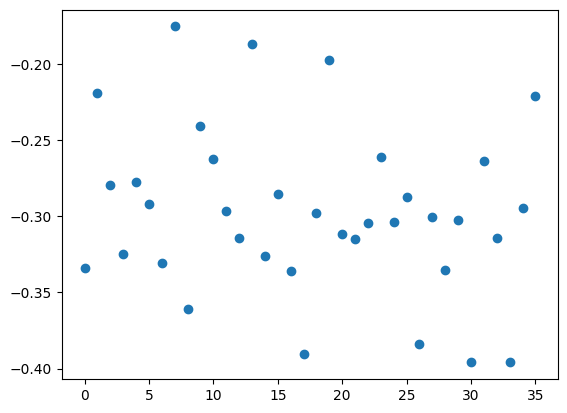

In [108]:
for c, child in enumerate(root.children):
    print(child.visits, child.value, child.value_rollmed.get_median(), 
          root.values_value_sum[c], root.children_values[c], child.move)
print()
print(root.select_child().move)

plt.scatter(range(len(root.children)), [child.value for child in root.children])
plt.show()

In [134]:
def count_red(node, boards, level, t0):

    redundancies_curr = 0

    for child in node.children:

        found = False
        for board in boards[level]:
            if (board == child.game.pieces).all():
                redundancies_curr += 1
                found = True
                break
        if not found:
            boards[level].append(child.game.pieces)
        
        if sum(len(b) for b in boards) % 200 == 0:
            print('{} -- {}'.format(sum(len(b) for b in boards), level))
        
        redundancies_curr += count_red(child, boards, level+1, t0)
    
    return redundancies_curr

In [135]:
tot_count = count_red(root, [[] for _ in range(10)], 0, time.time())
print(tot_count)

200 -- 3
400 -- 1
600 -- 3
800 -- 3
1000 -- 3
1200 -- 2
1400 -- 3
1600 -- 2
1800 -- 2
1800 -- 3
2000 -- 3
2200 -- 3
2200 -- 3
2400 -- 1
2600 -- 3
2800 -- 3
3000 -- 3
3000 -- 2
3000 -- 3
3200 -- 3
3400 -- 2
3600 -- 3
3800 -- 3
4000 -- 2
4200 -- 3
4400 -- 2
4600 -- 3
4800 -- 3
5000 -- 3
5200 -- 2
5400 -- 3
5600 -- 3
5600 -- 2
5800 -- 3
6000 -- 3
6000 -- 2
6200 -- 3
6400 -- 3
6600 -- 3
6800 -- 3
7000 -- 3
7200 -- 3
7400 -- 3
7600 -- 2
7600 -- 2
7600 -- 2
7600 -- 2
7800 -- 2
8000 -- 3
8200 -- 2
8400 -- 3
8600 -- 3
8800 -- 2
9000 -- 3
9200 -- 3
9400 -- 2
9600 -- 3
9800 -- 3
10000 -- 3
10200 -- 3
10400 -- 3
10600 -- 3
10800 -- 3
11000 -- 3
11200 -- 3
11400 -- 3
11600 -- 3
11800 -- 3
12000 -- 3
12200 -- 3
12400 -- 3
12600 -- 3
12800 -- 3
13000 -- 2
13200 -- 3
13400 -- 3
13600 -- 2
13800 -- 3
13800 -- 3
13800 -- 3
13800 -- 3
14000 -- 3
14200 -- 3
14400 -- 3
14400 -- 3
14400 -- 3
14600 -- 3
14800 -- 2
15000 -- 3
15200 -- 3
15200 -- 3
15200 -- 3
15400 -- 2
15600 -- 3
15600 -- 3
15800 -- 3
16000 

KeyboardInterrupt: 

In [5]:
for root_curr in roots:
    print(root.game.pieces)

[[14. 12. 13. 16. 15.  0. 12. 14.]
 [11.  0.  0. 11. 13.  0.  0.  0.]
 [ 0. 11. 11.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  3. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  2.  1.  1.  1.  1.]
 [ 4.  0.  0.  6.  0.  3.  0.  4.]]
[[14. 12. 13. 16. 15.  0. 12. 14.]
 [11.  0.  0. 11. 13.  0.  0.  0.]
 [ 0. 11. 11.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  3. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  2.  1.  1.  1.  1.]
 [ 4.  0.  0.  6.  0.  3.  0.  4.]]
[[14. 12. 13. 16. 15.  0. 12. 14.]
 [11.  0.  0. 11. 13.  0.  0.  0.]
 [ 0. 11. 11.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  3. 11.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  2.  1.  1.  1.  1.]
 [ 4.  0.  0.  6.  0.  3.  0.  4.]]
[[14. 12. 13. 16. 15.  0. 12. 14.]
 [11.  0.  0. 11. 13.  0.  0.  0.]
 [ 0. 11. 11.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  3. 11.]
 [ 0.  0.  0.  0.

[[14.  0.  0. 16. 15.  0.  0. 14.]
 [ 0. 11.  0. 13.  0.  0.  0. 11.]
 [ 0.  0.  0.  5. 11. 11.  0. 12.]
 [11.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2. 12.  0.  0. 11.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  1.  0.  0.  1.  1.  1.]
 [ 0.  6.  0.  4.  0.  3.  0.  4.]]
1337 -0.4096949100494385 -0.34715956449508667 0.07300562239797716 -0.2448431204224622 ((3, 4), (1, 3), 'knight')
1867 -0.4051060676574707 -0.3106587827205658 0.10919934159625946 -0.26987009823292796 ((7, 3), (5, 1), 'queen')
1196 -0.4368775486946106 -0.3031863570213318 0.11657650543011402 -0.22464142858863687 ((7, 3), (7, 2), 'queen')
1730 -0.4371591806411743 -0.32387202978134155 0.09612555281090564 -0.22767905750197392 ((6, 0), (4, 0), 'pawn double')
104857 -0.4250122904777527 0.06828968971967697 0.4530926396788528 -0.04395723448256156 ((7, 1), (5, 0), 'knight')
1570 -0.43159914016723633 -0.3283451199531555 0.09169191774098825 -0.2278980474999351 ((7, 3), (4, 0), 'queen')
11100 -0.39735516905784607 -0.1322631

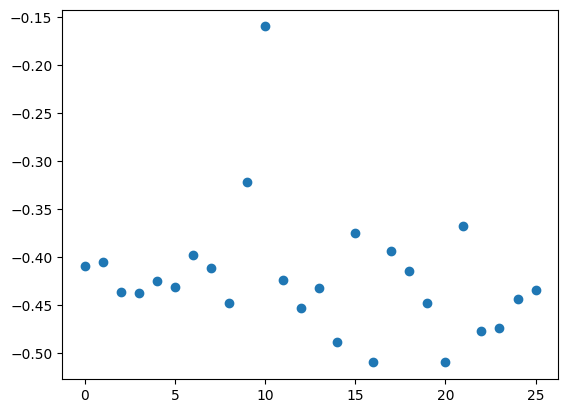

In [12]:
print(root.game.pieces)
for c, child in enumerate(root.children):
    print(child.visits, child.value, child.value_rollmed.get_median(), 
          root.values_value_sum[c], root.children_values[c], child.move)
print()
print(root.select_child().move)

plt.scatter(range(len(root.children)), [child.value for child in root.children])
plt.show()